In [732]:
test = type('container', (object,), {})()
#test.a=10
print(type(test))
print()


<class '__main__.container'>



In [733]:
test.

SyntaxError: invalid syntax (<ipython-input-733-4cc5a1d62b27>, line 1)

### This script is used to check BP for DCM-RNN
- Keep the majority parameters "correct".
- Calculate the loss as a function of remaining parameter.
- Check whether BP can find the targeted optimal point.

In [540]:
import importlib
import numpy as np
import scipy as sp
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import axes3d
import math as mth
from tensorflow.python.framework import ops
from IPython.display import clear_output
from scipy.interpolate import interp1d
import os,shutil
import pandas as pd
from tensorflow.python.client import timeline

In [17]:
import CBI
import population
importlib.reload(CBI)
importlib.reload(population)

<module 'population' from '/Users/yuanwang/Google_Drive/projects/Gits/DCM-RNN/population.py'>

###  Create a subject

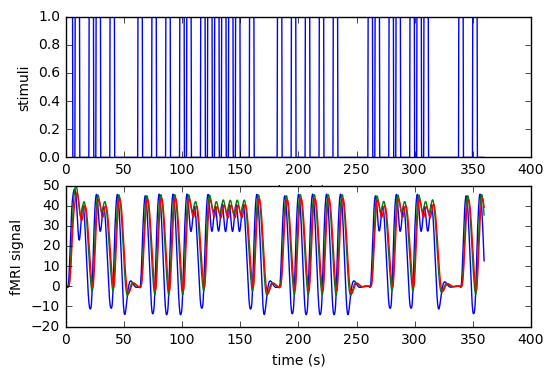

In [18]:
flags=lambda:None
flags.random_hemodynamic_parameter = False
flags.random_h_state_initial = False
flags.random_x_state_initial = False

s=population.get_a_subject(flags=flags)
m=CBI.configure_a_scanner(t_delta=0.25,n_stimuli=1)
u,y,x,h=m.quick_scan(s,return_x=True,return_h=True)
parameter_true=s.show_all_variable_value(False)
plt.subplot(211)
plt.plot(np.arange(m.n_time_point)*m.t_delta,u.transpose())
plt.xlabel('time (s)')
plt.ylabel('stimuli')
plt.subplot(212)
plt.plot(np.arange(m.n_time_point)*m.t_delta,y[:,0,:].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

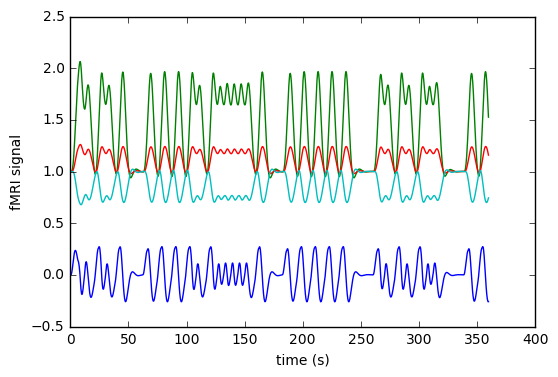

In [19]:
# plot it to check hemodynamic states to ensure they are in proper range
plt.plot(np.arange(m.n_time_point)*m.t_delta,h[2,:,:].transpose())
#plt.plot(np.arange(250,350),h[0,:,250:350].transpose())
plt.xlabel('time (s)')
plt.ylabel('fMRI signal')

### Data preparation

In [20]:
import data_helper
importlib.reload(data_helper)

<module 'data_helper' from '/Users/yuanwang/Google_Drive/projects/Gits/DCM-RNN/data_helper.py'>

In [21]:
# target u: [m.n_stimuli, n_recurrent_step]
# target x: [m.n_region, n_recurrent_step]
n_recurrent_step=12

dh=data_helper.get_a_data_helper()
dh.u=u[:]
dh.x=x[:]
dh.y=y[:]

dh.u_list=dh.cut2shape(dh.u,[m.n_stimuli, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.x_list=dh.cut2shape(dh.x,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
dh.y_list=dh.cut2shape(dh.y,[m.n_region, n_recurrent_step],n_recurrence=n_recurrent_step)
print('u_list has '+str(len(dh.u_list))+' segments, each of size '+str(dh.u_list[0].shape))
print('x_list has '+str(len(dh.x_list))+' segments, each of size '+str(dh.x_list[0].shape))
print('y_list has '+str(len(dh.x_list))+' segments, each of size '+str(dh.x_list[0].shape))

u_list has 120 segments, each of size (1, 12)
x_list has 120 segments, each of size (3, 12)
y_list has 120 segments, each of size (3, 12)


### Build model

In [522]:
# build DCM-RNN
ops.reset_default_graph()
import DCM_RNN
importlib.reload(DCM_RNN)
dr=DCM_RNN.create_a_dcm_rnn(m,n_recurrent_step=n_recurrent_step,learning_rate=0.00001)
util=DCM_RNN.utilities()

In [523]:
# training summary
acc_Wxx=1-util.rMSE(dr.Wxx,s.Wxx)
acc_Wxxu=[1-util.rMSE(dr.Wxxu[n],s.Wxxu[n]) for n in range(dr.n_stimuli)]
acc_Wxxu=tf.add_n(acc_Wxxu)
acc_Wxu=1-util.rMSE(dr.Wxu,s.Wxu.reshape((m.n_region,1)))

loss_summary = tf.scalar_summary('fMRI_prediction_loss',dr.total_loss_y)
acc_Wxx_summary = tf.scalar_summary('acc_Wxx',acc_Wxx)
acc_Wxxu_summary = tf.scalar_summary('acc_Wxxu',acc_Wxxu)
acc_Wxu_summary = tf.scalar_summary('acc_Wxu',acc_Wxu)
opt_summary = tf.merge_summary([loss_summary, acc_Wxx_summary, acc_Wxxu_summary,acc_Wxu_summary])

summary_dir = os.path.abspath(os.path.join(os.path.curdir, "summary"))

# remove existing files
for the_file in os.listdir(summary_dir):
    file_path = os.path.join(summary_dir, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

In [524]:
'''# time tracking
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()'''

'# time tracking\nrun_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)\nrun_metadata = tf.RunMetadata()'

In [525]:
# open session and initilize
try:
    isess
except:
    isess = tf.InteractiveSession()
else:
    isess.close()
    isess = tf.InteractiveSession()

opt_init_all=tf.initialize_all_variables()
isess.run(opt_init_all)
# add summary
summary_writer = tf.train.SummaryWriter(summary_dir, isess.graph)

### Calculate loss as function as a certain subset of parameters

#### 1D version

In [486]:
names=util.get_parameter_names(dr.grads_and_vars)
variable_dict=util.set_up_parameter_profile(isess.graph,names=names,mask_type='zeros')
variable_dict['rnn_cell/Wxu:0'].mask[1]=1

In [508]:
# find loss as a function of parameters
# f=open('timeline.json', 'w')
n_grids = 21
loss_values_static=[]
parameter_range = np.linspace(-0.5,1,n_grids)
for current_value in parameter_range:
    
    # set parameter value
    Wxx=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
    Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.4]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
    Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.4*dr.t_delta 
    Wxu[1]=current_value*dr.t_delta
    dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)
    
    n_epoch=1
    for epoch in range(n_epoch):
        loss_sum=0.
        x_feed=np.zeros((m.n_region,1),dtype=np.float32)
        h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]

        for i in range(0,len(dh.u_list)):
        #for i in range(1):
            feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
            feed_dict[dr.x_state_initial]=x_feed
            feed_dict[dr.rnn_u]=dh.u_list[i]
            feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
            util.add_gradient_mask_to_feed_dict(dr,feed_dict,variable_dict)
            
            x_feed,h_feed,loss_tmp = isess.run([dr.x_state_final,
                                                dr.h_state_final,
                                                dr.total_loss_y], feed_dict=feed_dict)
            
            loss_sum+=loss_tmp 
        loss_values_static.append(loss_sum)
        print("parameter {:g}, loss {:g}".format(current_value, loss_sum))


parameter -0.5, loss nan
parameter -0.425, loss nan
parameter -0.35, loss nan
parameter -0.275, loss nan
parameter -0.2, loss nan


KeyboardInterrupt: 

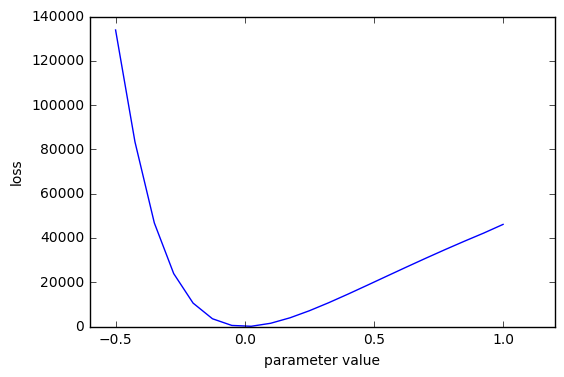

In [466]:
plt.plot(parameter_range,loss_values_static)
plt.xlabel('parameter value')
plt.ylabel('loss')

In [484]:
# set a particular initial point
parameter_initial=0
Wxx=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.4]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.4*dr.t_delta 
Wxu[1]=parameter_initial*dr.t_delta
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

In [485]:
# training
# f=open('timeline.json', 'w')
loss_values=[]
parameter_values=[]
parameter_values.append(parameter_initial)
n_epoch=12
for epoch in range(n_epoch):
    loss_sum=0.
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    #for i in range(0,len(dh.u_list)):
    # do not do BP for the first segments because of initial states uncertainty 
    
    for i in range(0,5):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.add_gradient_mask_to_feed_dict(dr,feed_dict,variable_dict)

        #grads_and_vars_tmp
        x_feed,h_feed, loss_tmp = isess.run([dr.x_state_final,dr.h_state_final, dr.total_loss_y,],feed_dict=feed_dict)
        loss_sum+=loss_tmp
    
    for i in range(5,len(dh.u_list)):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.add_gradient_mask_to_feed_dict(dr,feed_dict,variable_dict)
        
        grads_and_vars_tmp,tmp,x_feed,h_feed,loss_tmp, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([
                                                    dr.apply_gradient_y,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.total_loss_y,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],
                                                    feed_dict=feed_dict)
       
                                                      #options=run_options, run_metadata=run_metadata)
        #print("segment {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
        #  .format(i, loss_tmp, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
        
        #isess.run(dr.apply_gradient_y,feed_dict={})
        
        loss_sum+=loss_tmp 
        #tl = timeline.Timeline(run_metadata.step_stats)
        #ctf = tl.generate_chrome_trace_format()
    #f.write(ctf)
    summary_writer.add_summary(summaries, epoch)
    #print('epoch = '+str(epoch))
    parameter_tmp=isess.run(dr.Wxu)/dr.t_delta
    parameter_values.append(float(parameter_tmp[1]))
    loss_values.append(loss_sum)
    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
         .format(epoch, loss_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    

epoch 0, loss nan, acc_Wxx nan, acc_Wxxu nan, acc_Wxu nan


KeyboardInterrupt: 

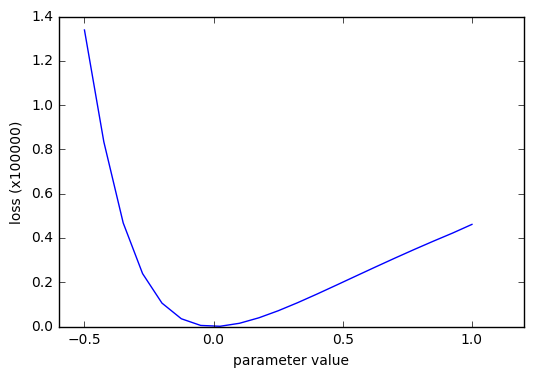

In [478]:
# plot the BP process
ax = plt.axes()
ax.plot(parameter_range,np.asarray(loss_values_static)/100000)
for idx in range(1,len(loss_values)):
    ax.arrow(float(parameter_values[idx-1]), loss_values[idx-1]/100000,\
             float(parameter_values[idx])-float(parameter_values[idx-1]), (loss_values[idx]-loss_values[idx-1])/100000)
plt.xlabel('parameter value')
plt.ylabel('loss (x100000)')
plt.show()

#### 2D version

In [713]:
n_grids = 19
loss_values_static=np.zeros((n_grids,n_grids))
parameter_range1 = np.linspace(0.3,1.2,n_grids)    # for A21
parameter_range2 = np.linspace(-0.2,0.7,n_grids)    # for C2
print(parameter_range1)
print(parameter_range2)


[ 0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65  0.7   0.75  0.8   0.85
  0.9   0.95  1.    1.05  1.1   1.15  1.2 ]
[ -2.00000000e-01  -1.50000000e-01  -1.00000000e-01  -5.00000000e-02
  -2.77555756e-17   5.00000000e-02   1.00000000e-01   1.50000000e-01
   2.00000000e-01   2.50000000e-01   3.00000000e-01   3.50000000e-01
   4.00000000e-01   4.50000000e-01   5.00000000e-01   5.50000000e-01
   6.00000000e-01   6.50000000e-01   7.00000000e-01]


In [714]:
# find loss as a function of parameters
# f=open('timeline.json', 'w')
n_grids = 19
loss_values_static=np.zeros((n_grids,n_grids))
parameter_range1 = np.linspace(0.3,1.2,n_grids)    # for A21
parameter_range2 = np.linspace(-0.2,0.7,n_grids)    # for C2

for idx1,current_value1 in enumerate(parameter_range1):
    for idx2,current_value2 in enumerate(parameter_range2):
    
        # set parameter value
        Wxx=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
        Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.4]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
        Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.4*dr.t_delta 
        Wxx[1,0]=current_value1*dr.t_delta
        Wxu[1]=current_value2*dr.t_delta
        dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

        n_epoch=1
        for epoch in range(n_epoch):
            loss_sum=0.
            x_feed=np.zeros((m.n_region,1),dtype=np.float32)
            h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]

            for i in range(0,len(dh.u_list)):
            #for i in range(1):
                feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
                feed_dict[dr.x_state_initial]=x_feed
                feed_dict[dr.rnn_u]=dh.u_list[i]
                feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
                util.add_gradient_mask_to_feed_dict(dr,feed_dict,variable_dict)

                x_feed,h_feed,loss_tmp = isess.run([dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.total_loss_y], feed_dict=feed_dict)

                loss_sum+=loss_tmp 
            loss_values_static[idx1,idx2]=loss_sum
            print("parameter1 {:g},parameter2 {:g}, loss {:g}".format(current_value1,current_value2, loss_sum))



parameter1 0.3,parameter2 -0.2, loss 59925
parameter1 0.3,parameter2 -0.15, loss 39848.1
parameter1 0.3,parameter2 -0.1, loss 25568.2
parameter1 0.3,parameter2 -0.05, loss 15638.2
parameter1 0.3,parameter2 -2.77556e-17, loss 8947.28
parameter1 0.3,parameter2 0.05, loss 4670.43
parameter1 0.3,parameter2 0.1, loss 2199.25
parameter1 0.3,parameter2 0.15, loss 1084.02
parameter1 0.3,parameter2 0.2, loss 990.13
parameter1 0.3,parameter2 0.25, loss 1666.64
parameter1 0.3,parameter2 0.3, loss 2923.79
parameter1 0.3,parameter2 0.35, loss 4617
parameter1 0.3,parameter2 0.4, loss 6635.27
parameter1 0.3,parameter2 0.45, loss 8892.88
parameter1 0.3,parameter2 0.5, loss 11323.3
parameter1 0.3,parameter2 0.55, loss 13874.7
parameter1 0.3,parameter2 0.6, loss 16506.4
parameter1 0.3,parameter2 0.65, loss 19186.7
parameter1 0.3,parameter2 0.7, loss 21890.6
parameter1 0.35,parameter2 -0.2, loss 51633.3
parameter1 0.35,parameter2 -0.15, loss 33860
parameter1 0.35,parameter2 -0.1, loss 21312.5
parameter1 

In [662]:
current_value1=0.725
current_value2=0
n_epoch=1
for epoch in range(n_epoch):
    loss_sum=0.
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]

    for i in range(0,len(dh.u_list)):
    #for i in range(1):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.add_gradient_mask_to_feed_dict(dr,feed_dict,variable_dict)

        x_feed,h_feed,loss_tmp = isess.run([dr.x_state_final,
                                            dr.h_state_final,
                                            dr.total_loss_y], feed_dict=feed_dict)

        loss_sum+=loss_tmp 
    loss_values_static[idx1,idx2]=loss_sum
    print("parameter1 {:g},parameter2 {:g}, loss {:g}".format(current_value1,current_value2, loss_sum))



parameter1 0.725,parameter2 0, loss 144.173


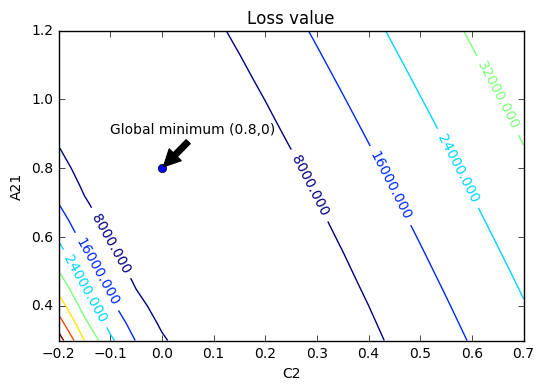

In [716]:
X, Y = np.meshgrid(parameter_range2, parameter_range1)
plt.figure()
CS = plt.contour(X, Y, loss_values_static)
plt.clabel(CS, inline=1, fontsize=10)
plt.annotate('Global minimum (0.8,0)', xy=(0, 0.8), xytext=(-0.1, 0.9),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.plot(0,0.8,'bo')
plt.title('Loss value')
plt.xlabel('C2')
plt.ylabel('A21')

In [717]:
# set a particular initial point
parameter_initial1=0.8
parameter_initial2=0.5
Wxx=np.array([[-1,0,0],[0.8,-1,0.4],[0.4,0.8,-1]],dtype=np.float32)*dr.t_delta+np.eye(dr.n_region,dr.n_region,0,dtype=np.float32)
Wxxu=Wxxu=[np.array([[0,0,0],[0,0,0],[0,0,-0.4]],dtype=np.float32)*dr.t_delta for _ in range(dr.n_stimuli)]
Wxu=np.eye(dr.n_region,dr.n_stimuli,dtype=np.float32)*0.4*dr.t_delta 
Wxx[1,0]=parameter_initial1*dr.t_delta
Wxu[1]=parameter_initial2*dr.t_delta
dr.set_connection_matrices(isess, Wxx=Wxx, Wxxu=Wxxu, Wxu=Wxu)

In [718]:
# set variable mask indecating the variables that can be updated
names=util.get_parameter_names(dr.grads_and_vars)
variable_dict=util.set_up_parameter_profile(isess.graph,names=names,mask_type='zeros')
variable_dict['rnn_cell/Wxx:0'].mask[1,0]=1
variable_dict['rnn_cell/Wxu:0'].mask[1]=1

In [719]:
# training
# f=open('timeline.json', 'w')
loss_values=[]
parameter_values1=[]
parameter_values2=[]
parameter_values1.append(parameter_initial1)
parameter_values2.append(parameter_initial2)
n_epoch=24
for epoch in range(n_epoch):
    loss_sum=0.
    x_feed=np.zeros((m.n_region,1),dtype=np.float32)
    h_feed=[np.array([0.,1.,1.,1.],dtype=np.float32).reshape(4,1) for _ in range(dr.n_region)]
    #for i in range(0,len(dh.u_list)):
    # do not do BP for the first segments because of initial states uncertainty 
    
    for i in range(0,5):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.add_gradient_mask_to_feed_dict(dr,feed_dict,variable_dict)

        #grads_and_vars_tmp
        x_feed,h_feed, loss_tmp = isess.run([dr.x_state_final,dr.h_state_final, dr.total_loss_y,],feed_dict=feed_dict)
        loss_sum+=loss_tmp
    
    for i in range(5,len(dh.u_list)):
        feed_dict={i: d for i, d in zip(dr.h_state_initial, h_feed)}
        feed_dict[dr.rnn_u]=dh.u_list[i]
        feed_dict[dr.x_state_initial]=x_feed
        feed_dict[dr.y_true_input_as_array]=dh.y_list[i]
        util.add_gradient_mask_to_feed_dict(dr,feed_dict,variable_dict)
        #grads_and_vars_tmp
        grads_and_vars_tmp,tmp,x_feed,h_feed,loss_tmp, summaries, acc_Wxx_tmp,acc_Wxxu_tmp,acc_Wxu_tmp \
                                                    = isess.run([
                                                    dr.apply_gradient_y,
                                                    dr.x_state_predicted,
                                                    dr.x_state_final,
                                                    dr.h_state_final,
                                                    dr.total_loss_y,
                                                    opt_summary,
                                                    acc_Wxx,
                                                    acc_Wxxu,
                                                    acc_Wxu],
                                                    feed_dict=feed_dict)
       
                                                      #options=run_options, run_metadata=run_metadata)
        #print("segment {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
        #  .format(i, loss_tmp, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
        
        #isess.run(dr.apply_gradient_y,feed_dict={})
        
        loss_sum+=loss_tmp 
        #tl = timeline.Timeline(run_metadata.step_stats)
        #ctf = tl.generate_chrome_trace_format()
    #f.write(ctf)
    summary_writer.add_summary(summaries, epoch)
    #print('epoch = '+str(epoch))
    parameter_tmp=isess.run(dr.Wxx)/dr.t_delta
    parameter_values1.append(float(parameter_tmp[1,0]))
    parameter_tmp=isess.run(dr.Wxu)/dr.t_delta
    parameter_values2.append(float(parameter_tmp[1]))
    loss_values.append(loss_sum)
    print("epoch {}, loss {:g}, acc_Wxx {:g}, acc_Wxxu {:g}, acc_Wxu {:g}"\
         .format(epoch, loss_sum, acc_Wxx_tmp, acc_Wxxu_tmp, acc_Wxu_tmp))
    

epoch 0, loss 16383.7, acc_Wxx 0.990082, acc_Wxxu 1, acc_Wxu 0.0649043
epoch 1, loss 9642.45, acc_Wxx 0.981556, acc_Wxxu 1, acc_Wxu 0.308808
epoch 2, loss 5081.2, acc_Wxx 0.974742, acc_Wxxu 1, acc_Wxu 0.487532
epoch 3, loss 2404.81, acc_Wxx 0.969662, acc_Wxxu 1, acc_Wxu 0.613616
epoch 4, loss 1034.92, acc_Wxx 0.966117, acc_Wxxu 1, acc_Wxu 0.70065
epoch 5, loss 426.903, acc_Wxx 0.96381, acc_Wxxu 1, acc_Wxu 0.760164
epoch 6, loss 204.209, acc_Wxx 0.962437, acc_Wxxu 1, acc_Wxu 0.800828
epoch 7, loss 151.695, acc_Wxx 0.961736, acc_Wxxu 1, acc_Wxu 0.828765
epoch 8, loss 162.282, acc_Wxx 0.961504, acc_Wxxu 1, acc_Wxu 0.848165
epoch 9, loss 188.764, acc_Wxx 0.961592, acc_Wxxu 1, acc_Wxu 0.861854
epoch 10, loss 213.175, acc_Wxx 0.961893, acc_Wxxu 1, acc_Wxu 0.871722
epoch 11, loss 230.393, acc_Wxx 0.962334, acc_Wxxu 1, acc_Wxu 0.879028
epoch 12, loss 240.279, acc_Wxx 0.962864, acc_Wxxu 1, acc_Wxu 0.884613
epoch 13, loss 244.247, acc_Wxx 0.96345, acc_Wxxu 1, acc_Wxu 0.889036
epoch 14, loss 243.

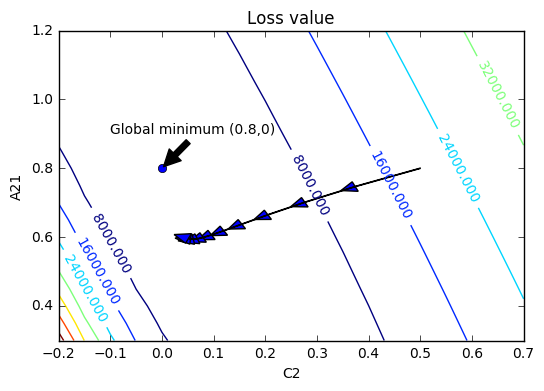

In [724]:
# plot the BP process
X, Y = np.meshgrid(parameter_range2, parameter_range1)

ax = plt.axes()
# plt.figure()
for idx in range(1,12):
    ax.arrow(float(parameter_values2[idx-1]), parameter_values1[idx-1],\
             float(parameter_values2[idx])-float(parameter_values2[idx-1]), (parameter_values1[idx]-parameter_values1[idx-1]),\
            head_width=0.03, head_length=0.03)

CS = plt.contour(X, Y, loss_values_static)
plt.clabel(CS, inline=1, fontsize=10)

plt.annotate('Global minimum (0.8,0)', xy=(0, 0.8), xytext=(-0.1, 0.9),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.plot(0,0.8,'bo')
plt.title('Loss value')
plt.xlabel('C2')
plt.ylabel('A21')
plt.show()


In [726]:
parameter_values1

[0.8,
 0.7469499707221985,
 0.7013576030731201,
 0.6649215221405029,
 0.6377536654472351,
 0.6187979578971863,
 0.6064612865447998,
 0.5991175174713135,
 0.595369815826416,
 0.5941308736801147,
 0.5946004986763,
 0.5962107181549072,
 0.5985683798789978,
 0.6014053821563721,
 0.6045398712158203,
 0.6078503131866455,
 0.6112550497055054,
 0.6147003769874573,
 0.618149995803833,
 0.6215808987617493,
 0.6249777674674988,
 0.6283304691314697,
 0.6316326260566711,
 0.6348812580108643,
 0.6380736231803894]

In [649]:
parameter_values2

[0.0,
 0.0041606249287724495,
 0.0071619246155023575,
 0.00932449009269476,
 0.010881464928388596,
 0.01200183853507042,
 0.012807738967239857,
 0.013387267477810383,
 0.01380393747240305,
 0.014103468507528305,
 0.01431877538561821,
 0.014473534189164639,
 0.014584769494831562]

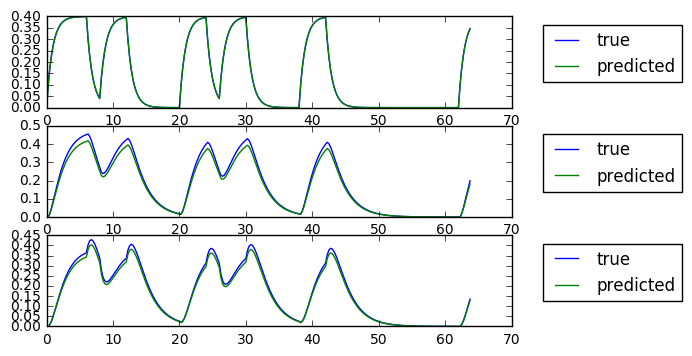

In [643]:
# visulize pridicted x_state and true x_state (after training)
x_predicted=util.forward_pass_x(dr,dh,isess)
n_monitor=256
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,x[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,x_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

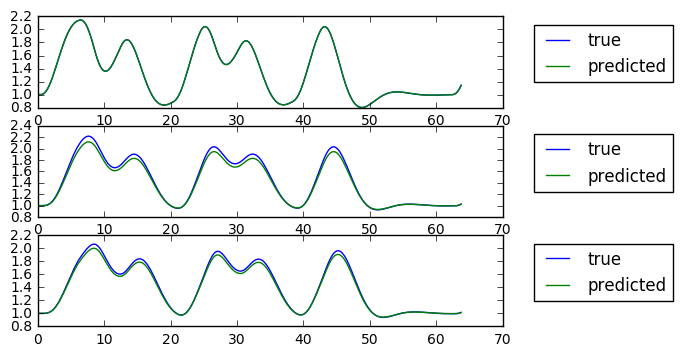

In [644]:
# visulize pridicted h_state and true h_state (before training)
h_predicted=util.forward_pass_h(dr,dh,isess)
n_monitor=256
i_h_state=1
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,h[n,i_h_state,0:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,h_predicted[n][i_h_state,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

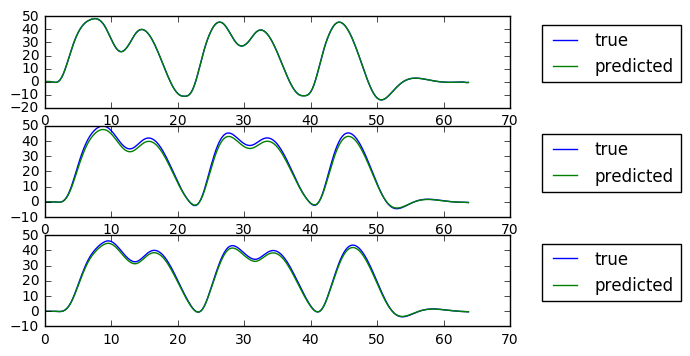

In [645]:
y_predicted=util.forward_pass_y(dr,dh,isess)
n_monitor=256#m.n_time_point
for n in range(m.n_region):
    plt.subplot(3,1,n+1)
    plt.plot(np.arange(n_monitor)*m.t_delta,y[n,0,:n_monitor].transpose(),label='true')
    plt.plot(np.arange(n_monitor)*m.t_delta,y_predicted[n,0:n_monitor].transpose(),label='predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [659]:
importlib.reload(DCM_RNN)
util=DCM_RNN.utilities()
parameter_trained=util.show_all_variable_value(dr,isess,visFlag=False)
tmp=util.compare_parameters(parameter_trained,parameter_true,visFlag=True,parameter_list=['Wxx','Wxxu_s0','Wxu','hemodynamic_parameters'])

Wxx


set1                    set2                 difference          \
       From_r0 From_r1 From_r2 From_r0 From_r1 From_r2    From_r0 From_r1   
To_r0  0.75000    0.00    0.00    0.75    0.00    0.00    0.00000     0.0   
To_r1  0.18125    0.75    0.10    0.20    0.75    0.10   -0.01875     0.0   
To_r2  0.10000    0.20    0.75    0.10    0.20    0.75    0.00000     0.0   

               
      From_r2  
To_r0     0.0  
To_r1     0.0  
To_r2     0.0

Wxxu_s0


set1                    set2                 difference          \
      From_r0 From_r1 From_r2 From_r0 From_r1 From_r2    From_r0 From_r1   
To_r0     0.0     0.0     0.0     0.0     0.0     0.0        0.0     0.0   
To_r1     0.0     0.0     0.0     0.0     0.0     0.0        0.0     0.0   
To_r2     0.0     0.0    -0.1     0.0     0.0    -0.1        0.0     0.0   

               
      From_r2  
To_r0     0.0  
To_r1     0.0  
To_r2     0.0

Wxu


,set1,set2,difference
,stimuli_0,stimuli_0,stimuli_0
To_r0,0.1,0.1,0.0
To_r1,0.0,0.0,0.0
To_r2,0.0,0.0,0.0


hemodynamic_parameters


alpha            E0             k         gamma  \
set1       region_0  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
           region_1  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
           region_2  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
set2       region_0  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
           region_1  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
           region_2  3.200000e-01  3.400000e-01  6.500000e-01  4.100000e-01   
difference region_0 -7.152557e-09  3.576279e-09 -2.384186e-08 -3.576279e-09   
           region_1 -7.152557e-09  3.576279e-09 -2.384186e-08 -3.576279e-09   
           region_2 -7.152557e-09  3.576279e-09 -2.384186e-08 -3.576279e-09   

                              tao       epsilon     V0            TE    r0  \
set1       region_0  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
           region_1  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
           region_2  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
set2       region_0  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
           region_1  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
           region_2  9.800000e-01  4.000000e-01  100.0  3.000000e-02  25.0   
difference region_0  1.907349e-08  5.960464e-09    0.0 -6.705523e-10   0.0   
           region_1  1.907349e-08  5.960464e-09    0.0 -6.705523e-10   0.0   
           region_2  1.907349e-08  5.960464e-09    0.0 -6.705523e-10   0.0   

                           theta0  
set1       region_0  4.030000e+01  
           region_1  4.030000e+01  
           region_2  4.030000e+01  
set2       region_0  4.030000e+01  
           region_1  4.030000e+01  
           region_2  4.030000e+01  
difference region_0 -7.629395e-07  
           region_1 -7.629395e-07  
           region_2 -7.629395e-07